## Modele

Dane niezbędne do prawidłowego funkcjonowania modelu przygotowywane są dzięki wykorzystaniu mechanizmu `pipeline` z biblioteki `sklearn`. Do wyboru cech (proces ich wybierania przebiega analogicznie jak ten zdefiniowany w *preprocessing_02.ipynb*) służy klasa **FeatureBuilder**. Następnie atrybuty są odpowiednio przetwarzane przez **Preprocessor** - uzupełnia on brakujące wartości i koduje atrybuty. 

Sprawdzone modele to:
1. Model bazowy - **Regresja liniowa**
2. Model docelowy - **Las losowy**

W procesie trenowania modelu używana jest metoda **walidacji krzyżowej**.

#### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

In [2]:
from sklearn.pipeline import Pipeline
from src.builder import FeatureBuilder
from src.preprocessor import Preprocessor

#### Wczytanie i przygotwanie odpowiednich danych do pipeline'u ML i ewaluacji modelu 

In [3]:
import pandas as pd
from src.transformations.target import convert_price_to_number
from sklearn.model_selection import KFold, cross_val_score
from sklearn.cluster import HDBSCAN
import numpy as np

listings = pd.read_csv("../data/listings.csv")
sessions = pd.read_csv("../data/sessions.csv")
target = convert_price_to_number(listings["price"])
listings.drop(columns=["price"], inplace=True)

coords_rad = np.radians(listings[["latitude", "longitude"]].to_numpy())
clusterer = HDBSCAN(
    min_cluster_size=15,
    min_samples=1,
    metric="haversine",
    cluster_selection_method="eom",
    copy=False,
)
ids = clusterer.fit_predict(coords_rad)

X = listings
y = target
cv = KFold(n_splits=5, shuffle=True, random_state=13)

#### Model bazowy - regresja liniowa

In [4]:
from sklearn.linear_model import LinearRegression

pipe_linear = Pipeline(
    [
        ("builder", FeatureBuilder(sessions)),
        ("preprocessor", Preprocessor()),
        ("regressor", LinearRegression()),
    ]
)

cv_scores = cross_val_score(pipe_linear, X, y, cv=cv, scoring="neg_mean_absolute_error")
mae = -cv_scores

pipe_linear.fit(X, y)

print(f"Mean CV linear MAE: {mae.mean():.2f} ± {mae.std():.2f}")

Mean CV linear MAE: 38.78 ± 1.51


#### Model docelowy - random forest

In [5]:
from sklearn.ensemble import RandomForestRegressor

pipe_random_forest = Pipeline(
    [
        ("builder", FeatureBuilder(sessions)),
        ("preprocessor", Preprocessor()),
        ("regressor", RandomForestRegressor(n_jobs=-1)),
    ]
)

cv_scores = cross_val_score(pipe_random_forest, X, y, cv=cv, scoring="neg_mean_absolute_error")
mae = -cv_scores

pipe_random_forest.fit(X, y)

print(f"Mean CV random forest MAE: {mae.mean():.2f} ± {mae.std():.2f}")

Mean CV random forest MAE: 33.94 ± 1.47


Las losowy wykazuje bardzo małą wrażliwość na strojenie hiperparametrów, dlatego zostały przyjęte wartości domyślne z biblioteki `sklearn`.

Interpretacja wykresów różnicy ceny danej i przewidzianej:
- Zielona belka - mediana dla klastra
- Środkowa sztabka - 50% środkowych wartości
- Knoty świec - skrajne predykcje

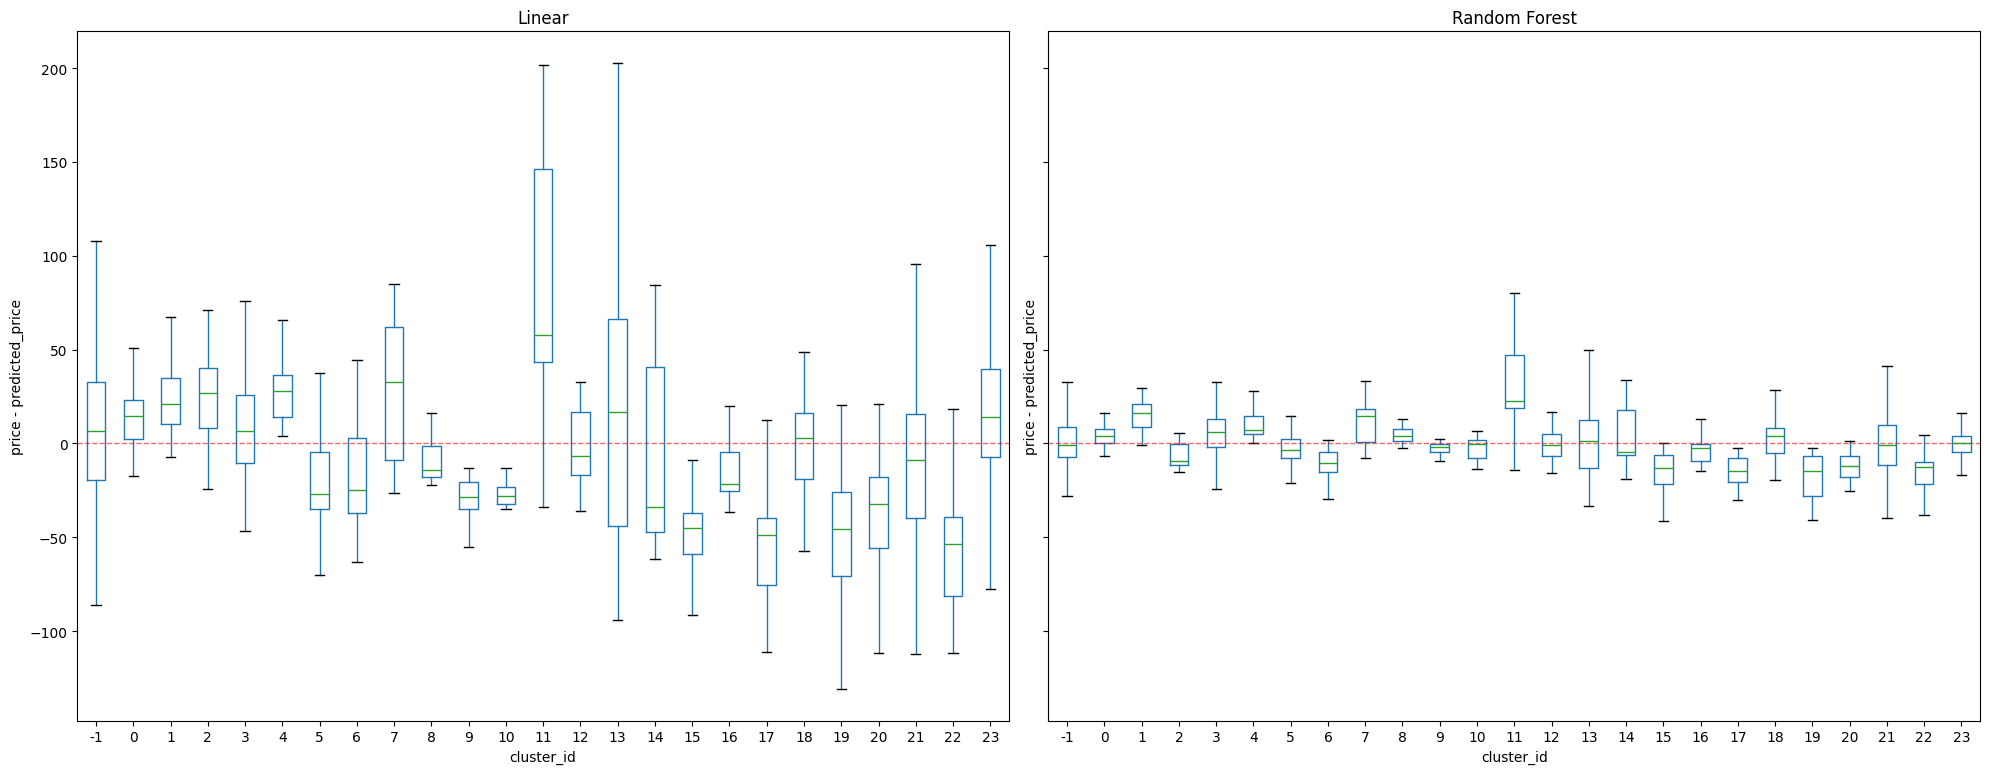

In [6]:
from src.visualizations.results import visualize_results_compare, visualize_map

predictions_linear = pipe_linear.predict(X)
diff_linear = y - predictions_linear
predictions_rf = pipe_random_forest.predict(X)
diff_rf = y - predictions_rf
visualize_results_compare(diff_linear, diff_rf, ids)

Interpretacja map
- Kolor zielony - zbyt mało ofert w regionie
- Kolor czerwony - zbyt dużo ofert w regionie

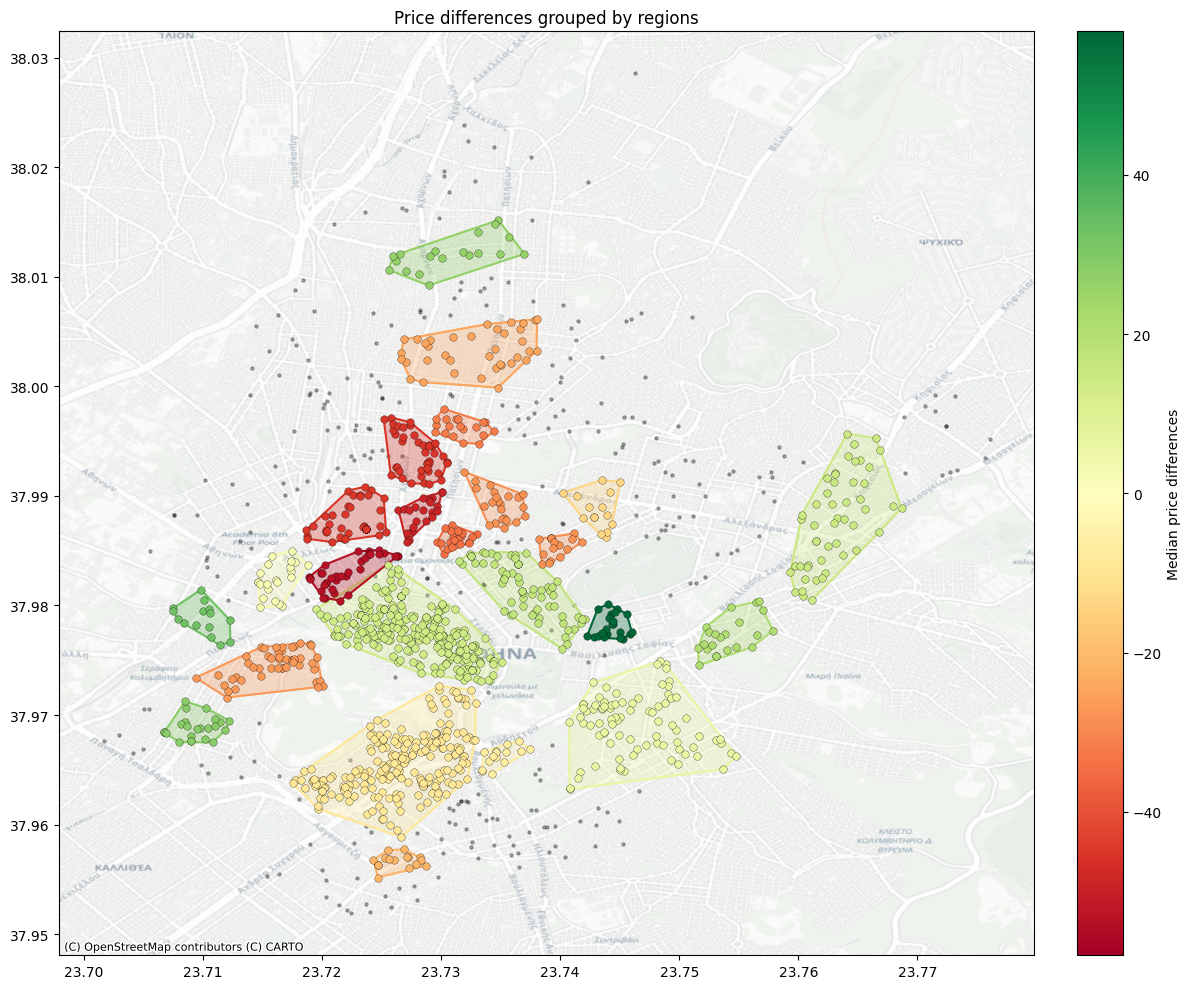

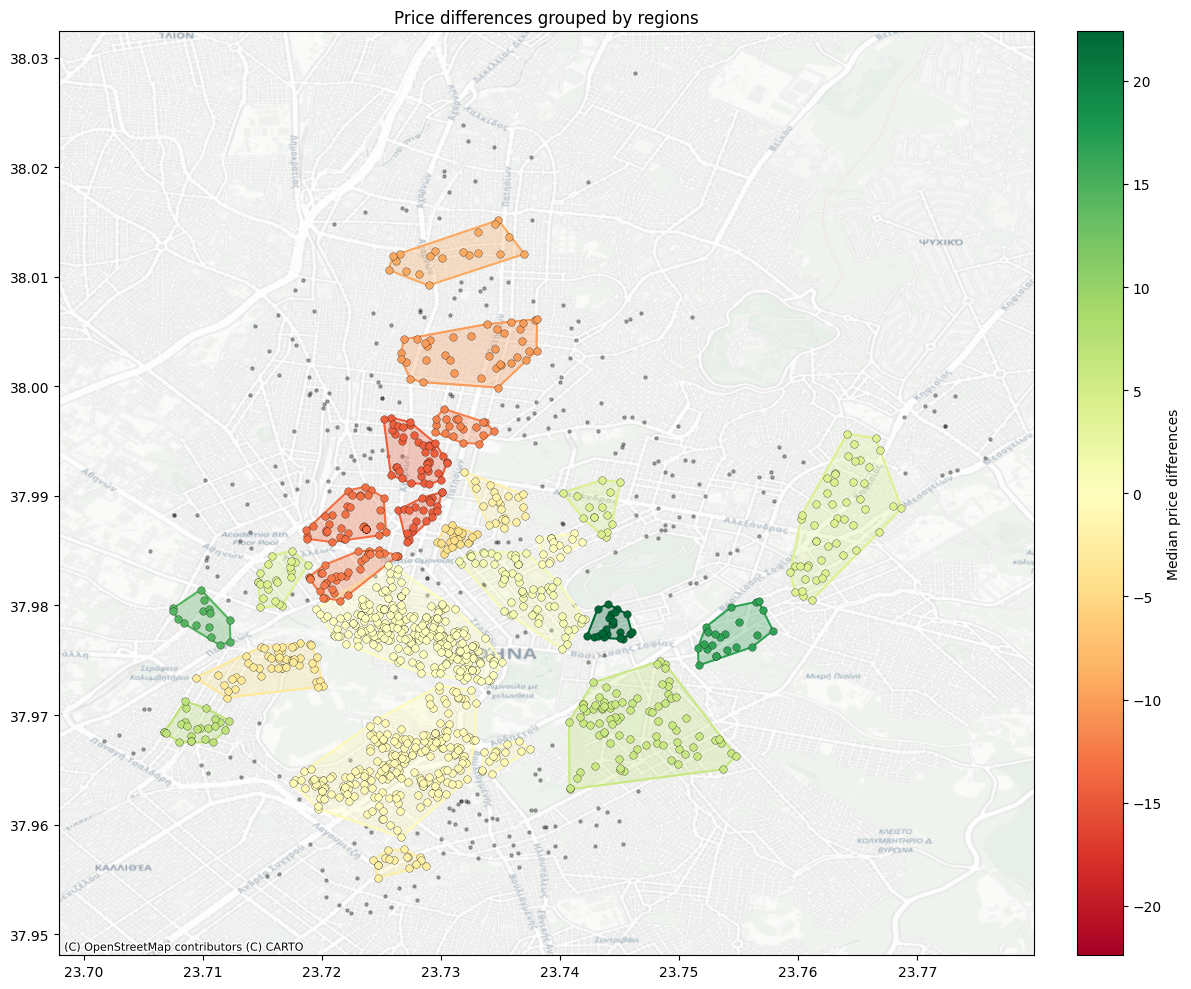

In [7]:
visualize_map(diff_linear, ids, listings)
visualize_map(diff_rf, ids, listings)

## Wnioski

1. **Błąd MAE** podczas uczenia modelu - różnica wartości między błędu między modelami jest niewielka. Nie mówi jasno czy stosowanie lasu losowego jest konieczne.
2. **Mapy** - wyniki dla obydwu modeli są stosunkowo podobne, trzeba się dobrze przyjrzeć, żeby zobaczyć różnicę.
3. **Wykresy statystyczne** - znacząco różnią się od siebie. Dla modelu regresji liniowej wyniki są bardziej skrajne, model nie jest w stanie wychwycić nieliniowych zależności, co prowadzi do bardzo dużych różnic predykcji w obrębie jednego klastra. Natomiast wyniki lasu losowego są bardziej stabilne, jest on w stanie dostrzec trudniejsze zależności, co przekłada się na mniej zaszumione wyniki.

Obserwacje wskazują, że w analizowanym problemie szukania regionów, w których liczba ofert jest zbyt duża **jest adekwatne** zastosowanie bardziej zaawansowanego modelu **lasu losowego**.